## Amazon Food Review - Naive Bayes

In [198]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from prettytable import PrettyTable
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings("ignore") 

In [3]:
df= pd.read_csv("../../../../Desktop/Prep/ML_Repo/amazon-fine-food-reviews/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
print(df.shape)

(568454, 10)


In [5]:
connection = sqlite3.connect('../../../../Desktop/Prep/ML_Repo/amazon-fine-food-reviews/database.sqlite')
filter_data = pd.read_sql_query("""SELECT * from Reviews where Score !=3""",connection)
actual_score =filter_data['Score']
pos_or_neg = actual_score.apply(lambda x:'Positive' if int(x)>3 else 'Negative')
filter_data['Score'] = pos_or_neg
filter_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
print(filter_data.shape)

(525814, 10)


In [7]:
display= pd.read_sql_query("""SELECT *FROM Reviews WHERE Score != 3 AND UserId="AR5J8UI46CURR" ORDER BY ProductID""", connection)
sorted_data = filter_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
drop_data = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},inplace=False,keep='first')
drop_data.shape

(364173, 10)

In [8]:
drop_data1= drop_data[drop_data['ProductId'].str[0]!='0' ]
drop_data1.shape

(364139, 10)

In [9]:
drop_data1=drop_data1[drop_data1.HelpfulnessNumerator<=drop_data1.HelpfulnessDenominator]
drop_data1.shape

(364137, 10)

In [10]:
drop_data1['Score'].value_counts()

Positive    307029
Negative     57108
Name: Score, dtype: int64

In [11]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english')

def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,'',sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

In [12]:
i=0
str1=' '
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in drop_data1['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(snow.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (drop_data1['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) 
                    if(drop_data1['Score'].values)[i] == 'Negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) 
    
    final_string.append(str1)
    i+=1

In [13]:
drop_data1['Cleaned_Text'] = final_string
drop_data1['Cleaned_Text'] = drop_data1['Cleaned_Text'].str.decode("utf-8")

In [14]:
drop_data1['Score'].value_counts()

Positive    307029
Negative     57108
Name: Score, dtype: int64

In [15]:
drop_data1 = drop_data1.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
drop_data1.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,Positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,Positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,Positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,Positive,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,Negative,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...


In [16]:
pos_neg = drop_data1['Score'].apply(lambda x: 1 if x=='Positive' else 0)
drop_data1['Score'] = pos_neg
drop_data1.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...


In [17]:
drop_data1 = drop_data1.head(40000)

In [18]:
drop_data1['Score'].value_counts()

1    35591
0     4409
Name: Score, dtype: int64

In [19]:
import pickle

def save_data(data,file):
    pickle.dump(data,open(file+".pkl","wb"))
    
def load_data(file):
    data = pickle.load(open(file+".pkl","rb"))
    return data

In [20]:
save_data(drop_data1,'40k_nb')

In [22]:
nb_data = load_data('40k_nb')
nb_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...


In [65]:
def acc_vs_kvalue_plot(cv_results):
    sns.set_style("whitegrid")
    alpha_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,0,1,10,50,100,500,1000]
    plt.plot([i for i in alpha_list],cv_results)
    plt.xlabel("Alpha Values")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Alpha-Values")
    plt.show()

In [32]:
def confusion_matrix_plot(y_test,pred):
    df_bow = pd.DataFrame(confusion_matrix(y_test, pred))  
    sns.heatmap(df_bow, annot=True)
    tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()
    print('True Positive',tp)
    print('True Negative',tn)
    print('False Positive',fp)
    print('False Negative',fn)

In [33]:
def metric_scores(y_test,pred):
    acc_scores = [[accuracy_score(y_test, pred)*100,precision_score(y_test,pred),recall_score(y_test,pred),f1_score(y_test,pred)]]
    acc_scores = pd.DataFrame(acc_scores,columns=['Accuracy','Precision score','Recall score','F1 score'])
    return acc_scores

In [199]:
def summary_of_scores():
    x = PrettyTable()
    x.field_names = ["Model", "Algorithm", "Best Alpha", "Best Accuracy"]
    x.add_row(["BOW","Multinomial NB", list(load_data('bow_grid_search_nb')['params'][np.argmax(load_data('bow_grid_search_nb')['mean_test_score'])].values())[0], max(load_data('bow_grid_search_nb')['mean_test_score'])*100])
    x.add_row(["BOW","Bernoulli NB", list(load_data('bow_grid_search_nb_2')['params'][np.argmax(load_data('bow_grid_search_nb_2')['mean_test_score'])].values())[0], max(load_data('bow_grid_search_nb_2')['mean_test_score'])*100])
    x.add_row(["Trigram","Multinomial NB", list(load_data('trigram_grid_search_nb')['params'][np.argmax(load_data('trigram_grid_search_nb')['mean_test_score'])].values())[0], max(load_data('trigram_grid_search_nb')['mean_test_score'])*100])
    x.add_row(["Trigram","Bernouli NB", list(load_data('trigram_grid_search_nb_2')['params'][np.argmax(load_data('trigram_grid_search_nb_2')['mean_test_score'])].values())[0], max(load_data('trigram_grid_search_nb_2')['mean_test_score'])*100])
    x.add_row(["Tf-Idf","Multinomial NB", list(load_data('tfidf_grid_search_nb')['params'][np.argmax(load_data('tfidf_grid_search_nb')['mean_test_score'])].values())[0], max(load_data('tfidf_grid_search_nb')['mean_test_score'])*100])
    x.add_row(["Tf-Idf","Bernoulli NB", list(load_data('tfidf_grid_search_nb_2')['params'][np.argmax(load_data('tfidf_grid_search_nb_2')['mean_test_score'])].values())[0], max(load_data('tfidf_grid_search_nb_2')['mean_test_score'])*100])
    x.add_row(["W2V","Bernoulli NB", list(load_data('w2v_grid_search_nb_2')['params'][np.argmax(load_data('w2v_grid_search_nb_2')['mean_test_score'])].values())[0], max(load_data('w2v_grid_search_nb_2')['mean_test_score'])*100])
    x.add_row(["Tf-Idf - W2v","Bernoulli NB", list(load_data('tfidf_w2v_grid_search_nb_2')['params'][np.argmax(load_data('tfidf_w2v_grid_search_nb_2')['mean_test_score'])].values())[0], max(load_data('tfidf_w2v_grid_search_nb_2')['mean_test_score'])*100])
    print(x)
    

In [539]:
def top_25_features(nb_optimal,vectorizer):
    a = []
    for i in range(25):
        b = []
        
        index_p = nb_optimal.feature_log_prob_[1, :].argsort()
        pos_class_prob_sorted = nb_optimal.feature_log_prob_[1, :][index_p[index_p.size-25+i]]
        b.append(pos_class_prob_sorted)
        b.append(np.take(vectorizer.get_feature_names(), index_p[index_p.size-25+i]))
        
        index_n = nb_optimal.feature_log_prob_[0, :].argsort()
        neg_class_prob_sorted = nb_optimal.feature_log_prob_[0, :][index_n[index_n.size-25+i]]
        b.append(neg_class_prob_sorted)
        b.append(np.take(vectorizer.get_feature_names(), index_n[index_n.size-25+i]))
        
        a.append(b) 
        
    a1 = pd.DataFrame(a)
    a1.columns = ['Positive Values','Positive Words','Negative Values','Negative Words']
    return a1   

### Bag of Words - MultinomialNB

In [540]:
x_train, x_test, y_train, y_test = train_test_split(nb_data['Cleaned_Text'] ,nb_data['Score'], test_size=0.3, random_state=0)
x_test.head()

346013    got excel servic movi arriv promis date qualit...
59348     recepi box produc good muffin need add egg mak...
2009      tast better look first thing said skeptic look...
381644    look gluten free cereal sweet one tast like co...
259086    navita natur certifi organ goji berri wonder s...
Name: Cleaned_Text, dtype: object

In [541]:
count_vect = CountVectorizer()
x_train = count_vect.fit_transform(x_train)
x_train = normalize(x_train)
x_test = count_vect.transform(x_test)
x_test = normalize(x_test)

In [28]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

In [29]:
nb = MultinomialNB()
time_split_cv = TimeSeriesSplit(n_splits = 5)
alpha_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,0,1,10,50,100,500,1000]
param_grid = {'alpha':alpha_list}
grid_search = GridSearchCV(nb,param_grid,cv=time_split_cv,verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.5s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 0, 1, 10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [30]:
save_data(grid_search.cv_results_,'bow_grid_search_nb')

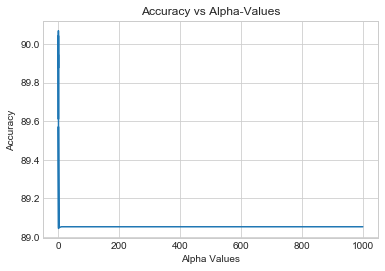

In [66]:
acc_vs_kvalue_plot(grid_search.cv_results_['mean_test_score']*100)

In [58]:
print('Best Alpha-Value ',grid_search.best_params_.get('alpha'))
print('Best Accuracy %f% %'%(grid_search.best_score_*100))

Best Alpha-Value  0.005
Best Accuracy 90.068581%


In [67]:
nb_optimal = MultinomialNB(alpha = grid_search.best_params_.get('alpha'))
nb_optimal.fit(x_train, y_train)
pred = nb_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [68]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,89.9,0.898792,0.998686,0.946109


True Positive 10639
True Negative 149
False Positive 1198
False Negative 14


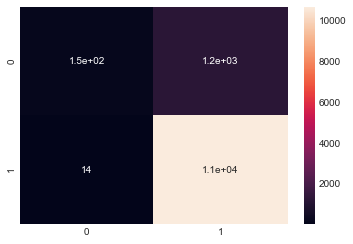

In [69]:
confusion_matrix_plot(y_test,pred)

### Bag of Words - BernoulliNB

In [542]:
nb = BernoulliNB()
time_split_cv = TimeSeriesSplit(n_splits = 5)
alpha_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,0,1,10,50,100,500,1000]
param_grid = {'alpha':alpha_list}
grid_search = GridSearchCV(nb,param_grid,cv=time_split_cv,verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    3.5s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 0, 1, 10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [71]:
save_data(grid_search.cv_results_,'bow_grid_search_nb_2')

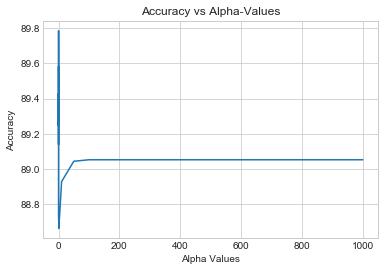

In [72]:
acc_vs_kvalue_plot(grid_search.cv_results_['mean_test_score']*100)

In [73]:
print('Best Alpha-Value ',grid_search.best_params_.get('alpha'))
print('Best Accuracy %f% %'%(grid_search.best_score_*100))

Best Alpha-Value  0.1
Best Accuracy 89.785684%


In [543]:
nb_optimal = BernoulliNB(alpha = grid_search.best_params_.get('alpha'))
nb_optimal.fit(x_train, y_train)
pred = nb_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [75]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,91.758333,0.945264,0.962921,0.954011


True Positive 10258
True Negative 753
False Positive 594
False Negative 395


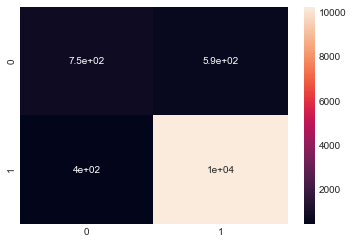

In [76]:
confusion_matrix_plot(y_test,pred)

### Top 25 Important Features for both Positive and Negative Class

In [544]:
top_25_features(nb_optimal,count_vect)

,Positive Values,Positive Words,Negative Values,Negative Words
0,-2.184249,littl,-2.245837,realli
1,-2.172209,much,-2.224468,bought
2,-2.167995,dont,-2.203547,amazon
3,-2.148901,amazon,-2.200594,love
4,-2.133207,tea,-2.200594,disappoint
5,-2.123438,would,-2.185957,food
6,-2.095016,realli,-2.174399,time
7,-2.065481,also,-2.151677,box
8,-2.032498,buy,-2.105042,eat
9,-2.028222,eat,-2.081207,make


### Trigram - MultinomialNB

In [545]:
x_train, x_test, y_train, y_test = train_test_split(nb_data['Cleaned_Text'] ,nb_data['Score'], test_size=0.3, random_state=0)
x_test.head()

346013    got excel servic movi arriv promis date qualit...
59348     recepi box produc good muffin need add egg mak...
2009      tast better look first thing said skeptic look...
381644    look gluten free cereal sweet one tast like co...
259086    navita natur certifi organ goji berri wonder s...
Name: Cleaned_Text, dtype: object

In [546]:
ngram_vect = CountVectorizer(ngram_range=(1,3))
x_train = ngram_vect.fit_transform(x_train)
x_train = normalize(x_train)
x_test = ngram_vect.transform(x_test)
x_test = normalize(x_test)

In [117]:
nb = MultinomialNB()
time_split_cv = TimeSeriesSplit(n_splits = 5)
alpha_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,0,1,10,50,100,500,1000]
param_grid = {'alpha':alpha_list}
grid_search = GridSearchCV(nb,param_grid,cv=time_split_cv,verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   14.9s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 0, 1, 10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [118]:
save_data(grid_search.cv_results_,'trigram_grid_search_nb')

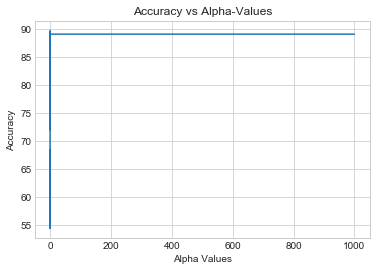

In [119]:
acc_vs_kvalue_plot(grid_search.cv_results_['mean_test_score']*100)

In [120]:
print('Best Alpha-Value ',grid_search.best_params_.get('alpha'))
print('Best Accuracy %f% %'%(grid_search.best_score_*100))

Best Alpha-Value  0
Best Accuracy 89.657094%


In [123]:
nb_optimal = MultinomialNB(alpha = grid_search.best_params_.get('alpha'))
nb_optimal.fit(x_train, y_train)
pred = nb_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [124]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,89.558333,0.89609,0.998123,0.944358


True Positive 10633
True Negative 114
False Positive 1233
False Negative 20


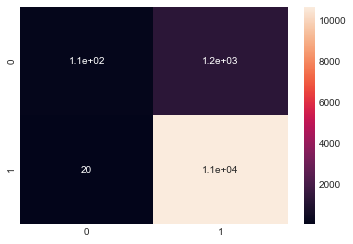

In [125]:
confusion_matrix_plot(y_test,pred)

### Trigram -BernoulliNB

In [547]:
nb = BernoulliNB()
time_split_cv = TimeSeriesSplit(n_splits = 5)
alpha_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,0,1,10,50,100,500,1000]
param_grid = {'alpha':alpha_list}
grid_search = GridSearchCV(nb,param_grid,cv=time_split_cv,verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   34.6s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 0, 1, 10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [204]:
save_data(grid_search.cv_results_,'trigram_grid_search_nb_2')

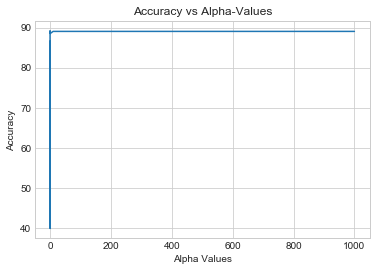

In [205]:
acc_vs_kvalue_plot(grid_search.cv_results_['mean_test_score']*100)

In [206]:
print('Best Alpha-Value ',grid_search.best_params_.get('alpha'))
print('Best Accuracy %f% %'%(grid_search.best_score_*100))

Best Alpha-Value  0
Best Accuracy 89.215602%


In [548]:
nb_optimal = BernoulliNB(alpha = grid_search.best_params_.get('alpha'))
nb_optimal.fit(x_train, y_train)
pred = nb_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [208]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,89.491667,0.896823,0.996245,0.943923


True Positive 10613
True Negative 126
False Positive 1221
False Negative 40


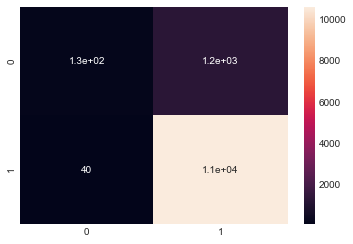

In [209]:
confusion_matrix_plot(y_test,pred)

### Top 25 Important Features for both Positive and Negative Class

In [549]:
top_25_features(nb_optimal,ngram_vect)

,Positive Values,Positive Words,Negative Values,Negative Words
0,-2.184276,littl,-2.246080,realli
1,-2.172237,much,-2.224705,bought
2,-2.168022,dont,-2.203778,amazon
3,-2.148927,amazon,-2.200823,love
4,-2.133233,tea,-2.200823,disappoint
5,-2.123463,would,-2.186182,food
6,-2.095041,realli,-2.174621,time
7,-2.065504,also,-2.151893,box
8,-2.032521,buy,-2.105245,eat
9,-2.028244,eat,-2.081403,make


### Word2Vec - Bernoulli NB

In [138]:
x_train, x_test, y_train, y_test = train_test_split(nb_data['Cleaned_Text'] ,nb_data['Score'], test_size=0.3, random_state=0)
x_train.head()

420113    sho like serious realli good quit cheesi mix p...
163143    first loos leaf tea ever tri direct said teasp...
355051    youv ever eaten indian food good restaur india...
421880    purchas birthday gift friend hoot hit natur ch...
17807     disappoint qualiti product smell stale tast su...
Name: Cleaned_Text, dtype: object

In [139]:
list_of_sent = []
for sent in x_train.values:
    list_of_sent.append(sent.split())

In [140]:
w2v_model = Word2Vec(list_of_sent,min_count=5,workers=4,size=100)

In [141]:
w2v_words = list(w2v_model.wv.vocab)

In [142]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            #print(sent_vec)
            cnt_words += 1
            #print(cnt_words)
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [143]:
sent_vectors_arr = np.asarray(sent_vectors)

In [144]:
sent_vectors_normalize = normalize(sent_vectors_arr)

In [145]:
x_train, x_test, y_train, y_test = train_test_split(sent_vectors_normalize ,y_train, test_size=0.3, random_state=0)

In [148]:
nb = BernoulliNB()
time_split_cv = TimeSeriesSplit(n_splits = 5)
alpha_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,0,1,10,50,100,500,1000]
param_grid = {'alpha':alpha_list}
grid_search = GridSearchCV(nb,param_grid,cv=time_split_cv,verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    4.1s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 0, 1, 10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [149]:
save_data(grid_search.cv_results_,'w2v_grid_search_nb_2')

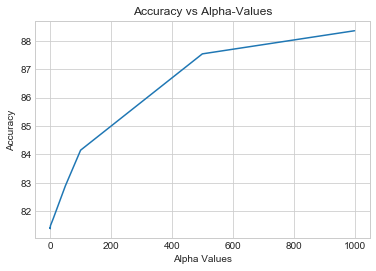

In [150]:
acc_vs_kvalue_plot(grid_search.cv_results_['mean_test_score']*100)

In [151]:
print('Best Alpha-Value ',grid_search.best_params_.get('alpha'))
print('Best Accuracy %f% %'%(grid_search.best_score_*100))

Best Alpha-Value  1000
Best Accuracy 88.352725%


In [152]:
nb_optimal = BernoulliNB(alpha = grid_search.best_params_.get('alpha'))
nb_optimal.fit(x_train, y_train)
pred = nb_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [153]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,87.345238,0.898744,0.966685,0.931477


True Positive 7225
True Negative 112
False Positive 814
False Negative 249


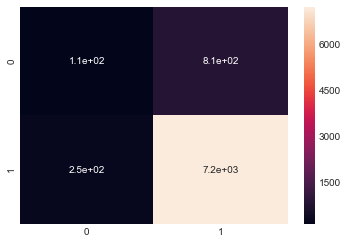

In [154]:
confusion_matrix_plot(y_test,pred)

### Tfidf - Multinomial NB

In [550]:
x_train, x_test, y_train, y_test = train_test_split(nb_data['Cleaned_Text'] ,nb_data['Score'], test_size=0.3, random_state=0)
x_train.head()

420113    sho like serious realli good quit cheesi mix p...
163143    first loos leaf tea ever tri direct said teasp...
355051    youv ever eaten indian food good restaur india...
421880    purchas birthday gift friend hoot hit natur ch...
17807     disappoint qualiti product smell stale tast su...
Name: Cleaned_Text, dtype: object

In [551]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_train = tf_idf_vect.fit_transform(x_train)
x_train = normalize(x_train)
x_test = tf_idf_vect.transform(x_test)
x_test = normalize(x_test)

In [320]:
nb = MultinomialNB()
time_split_cv = TimeSeriesSplit(n_splits = 5)
alpha_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,0,1,10,50,100,500,1000]
param_grid = {'alpha':alpha_list}
grid_search = GridSearchCV(nb,param_grid,cv=time_split_cv,verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    5.7s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 0, 1, 10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [158]:
save_data(grid_search.cv_results_,'tfidf_grid_search_nb')

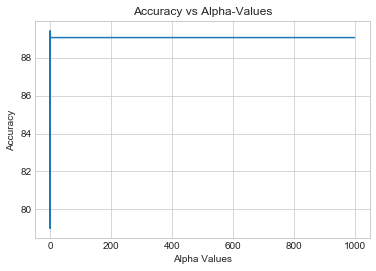

In [159]:
acc_vs_kvalue_plot(grid_search.cv_results_['mean_test_score']*100)

In [160]:
print('Best Alpha-Value ',grid_search.best_params_.get('alpha'))
print('Best Accuracy %f% %'%(grid_search.best_score_*100))

Best Alpha-Value  0
Best Accuracy 89.412773%


In [161]:
nb_optimal = MultinomialNB(alpha = grid_search.best_params_.get('alpha'))
nb_optimal.fit(x_train, y_train)
pred = nb_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [162]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,89.4,0.895522,0.996902,0.943497


True Positive 10620
True Negative 108
False Positive 1239
False Negative 33


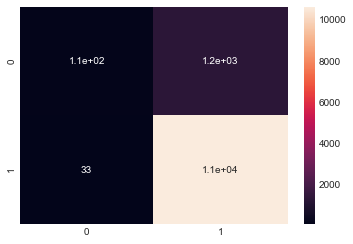

In [163]:
confusion_matrix_plot(y_test,pred)

### Tfidf BernoulliNB

In [552]:
nb = BernoulliNB()
time_split_cv = TimeSeriesSplit(n_splits = 5)
alpha_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,0,1,10,50,100,500,1000]
param_grid = {'alpha':alpha_list}
grid_search = GridSearchCV(nb,param_grid,cv=time_split_cv,verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    8.1s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 0, 1, 10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [322]:
save_data(grid_search.cv_results_,'tfidf_grid_search_nb_2')

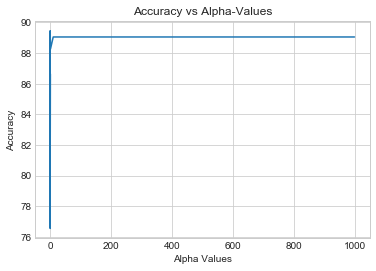

In [323]:
acc_vs_kvalue_plot(grid_search.cv_results_['mean_test_score']*100)

In [553]:
nb_optimal = BernoulliNB(alpha = grid_search.best_params_.get('alpha'))
nb_optimal.fit(x_train, y_train)
pred = nb_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [221]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,89.45,0.896712,0.99587,0.943693


True Positive 10609
True Negative 125
False Positive 1222
False Negative 44


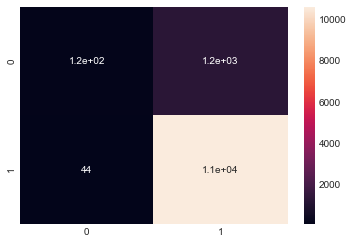

In [222]:
confusion_matrix_plot(y_test,pred)

### Top 25 Important Features for both Positive and Negative Class

In [554]:
top_25_features(nb_optimal,tf_idf_vect)

,Positive Values,Positive Words,Negative Values,Negative Words
0,-2.184276,littl,-2.246080,realli
1,-2.172237,much,-2.224705,bought
2,-2.168022,dont,-2.203778,amazon
3,-2.148927,amazon,-2.200823,love
4,-2.133233,tea,-2.200823,disappoint
5,-2.123463,would,-2.186182,food
6,-2.095041,realli,-2.174621,time
7,-2.065504,also,-2.151893,box
8,-2.032521,buy,-2.105245,eat
9,-2.028244,eat,-2.081403,make


### Tfidf- Word2Vec BernoulliNB

In [178]:
x_train, x_test, y_train, y_test = train_test_split(nb_data['Cleaned_Text'] ,nb_data['Score'], test_size=0.3, random_state=0)
x_test.head()

346013    got excel servic movi arriv promis date qualit...
59348     recepi box produc good muffin need add egg mak...
2009      tast better look first thing said skeptic look...
381644    look gluten free cereal sweet one tast like co...
259086    navita natur certifi organ goji berri wonder s...
Name: Cleaned_Text, dtype: object

In [179]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_train = tf_idf_vect.fit_transform(x_train)

In [180]:
tfidf_feat= tf_idf_vect.get_feature_names()
tfidf_sent_vectors = []
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if ((word in w2v_words) and (word in tfidf_feat)):
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = x_train[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    if row == (x_train.shape[0]):
        break

In [181]:
tfidf_sent_vectors_arr = np.asarray(tfidf_sent_vectors)

In [182]:
tfidf_sent_vectors_normalize = normalize(tfidf_sent_vectors_arr)

In [183]:
tfidf_sent_vectors_normalize.shape
df_scores = nb_data['Score'].head(tfidf_sent_vectors_normalize.shape[0])

In [184]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_sent_vectors_normalize ,df_scores, test_size=0.3, random_state=0)
y_train.shape

(19600,)

In [187]:
nb = BernoulliNB()
time_split_cv = TimeSeriesSplit(n_splits = 5)
alpha_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,0,1,10,50,100,500,1000]
param_grid = {'alpha':alpha_list}
grid_search = GridSearchCV(nb,param_grid,cv=time_split_cv,verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    3.6s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 0, 1, 10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [194]:
save_data(grid_search.cv_results_,'tfidf_w2v_grid_search_nb_2')

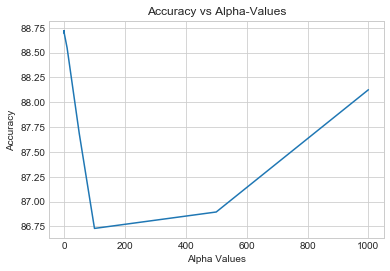

In [189]:
acc_vs_kvalue_plot(grid_search.cv_results_['mean_test_score']*100)

In [190]:
print('Best Alpha-Value ',grid_search.best_params_.get('alpha'))
print('Best Accuracy %f% %'%(grid_search.best_score_*100))

Best Alpha-Value  0.0005
Best Accuracy 88.720147%


In [191]:
nb_optimal = BernoulliNB(alpha = grid_search.best_params_.get('alpha'))
nb_optimal.fit(x_train, y_train)
pred = nb_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [192]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,89.261905,0.892619,1.0,0.943263


True Positive 7498
True Negative 0
False Positive 902
False Negative 0


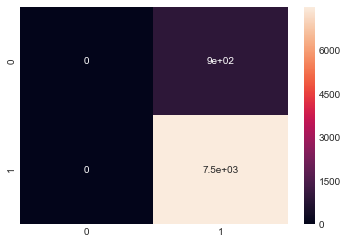

In [193]:
confusion_matrix_plot(y_test,pred)

### Summary of the various Naive Bayes Algorithm

In [200]:
summary_of_scores()

+--------------+----------------+------------+-------------------+
|    Model     |   Algorithm    | Best Alpha |   Best Accuracy   |
+--------------+----------------+------------+-------------------+
|     BOW      | Multinomial NB |   0.005    |  90.0685812258894 |
|     BOW      |  Bernoulli NB  |    0.1     | 89.78568366909559 |
|   Trigram    | Multinomial NB |     0      | 89.65709387055294 |
|   Trigram    |  Bernouli NB   |     0      | 89.21560222888985 |
|    Tf-Idf    | Multinomial NB |     0      |  89.4127732533219 |
|    Tf-Idf    |  Bernoulli NB  |     0      | 89.45992284612088 |
|     W2V      |  Bernoulli NB  |    1000    | 88.35272504592774 |
| Tf-Idf - W2v |  Bernoulli NB  |   0.0005   | 88.72014696876913 |
+--------------+----------------+------------+-------------------+
